In [1]:
"""
Created on Thu Aug  1 14:46:45 2019

@author: npittman

For some reason this doesnt work with modern version of xarray. Who uses HDF3 anyway. So yeah I have the environment Pacific_carbon that works. see the git repo. 
Otherwise idk good luck.

This file is used to download NPP Satellite Data / Algorithms from the Oregon State Website. It then Processes them into usable Netcdf files by modern versions of xarray.

YOU NEED TO USE XR.__version<=0.15.1 

"""

'\nCreated on Thu Aug  1 14:46:45 2019\n\n@author: npittman\n\nFor some reason this doesnt work with modern version of xarray. Who uses HDF3 anyway. So yeah I have the environment Pacific_carbon that works. see the git repo. \nOtherwise idk good luck.\n\n'

In [2]:
import requests                      #Version '2.19.1'
import xarray as xr                  #Version '0.11.3'
import numpy as np                   #Version '1.16.1' (Not used here, but in chl_tpca_algorithms)
import matplotlib.pyplot as plt      #Version '3.0.0'
import os
from bs4 import BeautifulSoup
import multiprocessing
import sys
import pandas as pd
from tarfile import TarFile
import gzip
import subprocess
import calendar
import shutil

In [ ]:
xr.__version # Cant guarantee this will work with versions > 0.15.1 

In [3]:
#Change this to your working directory.
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [4]:
def gzipper(inf,outf):
    try:
        inp = gzip.GzipFile(inf, 'rb')
        s = inp.read()
        inp.close()
        outp = open(outf, 'wb')
        outp.write(s)
        outp.close()
        return outf
    except:
        return False

In [5]:
def downloader(urls,sensor='viirs',ppname='vgpm'):
    """" Function designed to download satellite data from http://orca.science.oregonstate.edu/"""
    path='datasets/npp_satellite/'+ppname+'_'+sensor
    path1=path+'_extracted'
    path2=path+'_opened'
    path3=path+'_converted'
    path4=path+'_nc'
    
    def exists(fileloc):
        #print(fileloc)
        try:
            tar=TarFile.open(fileloc)
            tar.extractall(path1)
            return True
        except:
            return False
            
        #TarFile.extractall(tar)

        #try:
        #    
        #    return True
        #except:
        #    return False
    if not os.path.isdir('datasets'):
        print('Creating directory: ','datasets')
        os.makedirs('datasets')  
    if not os.path.isdir('datasets/npp_satellite/'):
        print('Creating directory: ','datasets/npp_satellite/')
        os.makedirs('datasets/npp_satellite/')  

    if not os.path.isdir(path):
        print('Creating directory: ',path)
        os.makedirs(path)    
    if not os.path.isdir(path1):
        print('Creating directory: ',path1)
        os.makedirs(path1)    
    if not os.path.isdir(path2):
        print('Creating directory: ',path2)
        os.makedirs(path2)  
        
    if not os.path.isdir(path3):
        print('Creating directory: ',path3)
        os.makedirs(path3)  
        
    if not os.path.isdir(path4):
        print('Creating directory: ',path4)
        os.makedirs(path4)     
        
    file_locations=[]
    count=0
    for url in urls:
        while True:
        #Download the files to their file name in the directory we just created.
        #ie: seawifs_data/S2000001.L3m_DAY_RRS_Rrs_443_9km.nc
            try:
                fileloc=path+'/'+url.split('/')[-1]
            except:
               # print('something broke at:',url)
                continue
            print(url)
            if exists(fileloc):
                print('Exists: ',fileloc)
                file_locations.append(fileloc)
                break
            r = requests.get(url)#,timeout=s20)
            with open(fileloc, 'wb') as f:
                f.write(r.content)
    
            #Ensure that the file actually downloaded, this can fail sometimes for some reason, maybe too soon.
            #time.sleep(1) #Can fail sometimes so maybe this is a fix
            if (r.status_code==200) & (exists(fileloc)==True):
                print('Downloaded: ',fileloc)
                file_locations.append(fileloc)
                break
            else:
                print('Download failed:', fileloc,'status:',r.status_code)
                count+=1
                if count>=10:
                    break
    return file_locations

In [6]:
def unzip_extract_convert(sensor='viirs',ppname='vgpm'):
    print('Unzipping the bz')
    fp='datasets/npp_satellite/'+ppname+'_'+sensor
    for f in os.listdir(fp+'_extracted'):
        gzipper(fp+'_extracted/'+f,fp+'_opened/'+f[0:-3])
    #sh fly_converter.sh vgpm_sw_opened/vgpm.2012092.hdf vgpm_sw_converted/test.hd5
    
    #print('Use h4toh5 binary software to convert, change the vars around and save as nc')
    #print('h4toh5 tool located at: https://support.hdfgroup.org/products/hdf5_tools/h4toh5/download.html')
    #Located from https://support.hdfgroup.org/products/hdf5_tools/h4toh5/download.html
    for f in os.listdir(fp+'_opened'):
        fname=f
        
        #Older version of xarray needed h4toh5 but this seems to work now in updated version.
        #subprocess.run(["./h4toh5",fp+'_opened/'+f,fp+'_converted/'+fname])
        #print('Opening : ' +str(f))
        dat=xr.open_dataset(fp+'_opened/'+fname) #Pynio was needed but maybe no more,engine='pynio')
        dat=dat.rename({'fakeDim0':'lat','fakeDim1':'lon'})
        #dat['lat']=np.arange(-90,90,180/len(dat.lat))*-1
        #dat['lon']=np.arange(-180,180,360/len(dat.lon))
        dat['lat']=np.linspace(-90,90,len(dat.lat))*-1
        dat['lon']=np.linspace(-180,180,len(dat.lon))
        #print(dat.attrs)
        
        dat['time']=np.datetime64(dat.attrs['Start Time String'][6:10]+'-'+dat.attrs['Start Time String'][0:2]+'-'+dat.attrs['Start Time String'][3:5])
        dat=dat.assign_coords(lon=(dat.lon % 360)).roll(lon=(dat.dims['lon'] // 2), roll_coords=True)	
        dat=dat.sel(lat=slice(20,-20))
        dat=dat.sel(lon=slice(120,290))
        dat=dat.assign_coords({'time':dat.time})
        #print(final_dat)
        # outp=sensor+'_'+ppname+'_'+dat.attrs['Start Time String'][6:10]+'-'+dat.attrs['Start Time String'][0:2]+'-'+dat.attrs['Start Time String'][3:5]
        dat.to_netcdf('datasets/npp_satellite/'+ppname+'_'+sensor+'_nc/'+sensor+'_'+f[0:-3]+'nc')
        
    print('Deleting unneccessary Data...')
    shutil.rmtree(r'datasets/npp_satellite/'+ppname+'_'+sensor+'_extracted', ignore_errors=True)
    shutil.rmtree(r'datasets/npp_satellite/'+ppname+'_'+sensor+'_opened', ignore_errors=True)
    shutil.rmtree(r'datasets/npp_satellite/'+ppname+'_'+sensor+'_converted', ignore_errors=True)

In [7]:
sensor,ppname,viirs_cbpm='viirs','cbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.viirs.r2018/hdf/cbpm.v.2020.tar']

In [8]:
sensor,ppname,viirs_eppley='viirs','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2014.tar',        
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.v.chl.v.sst/hdf/eppley.v.2021.tar']

In [9]:
sensor,ppname,viirs_vgpm='viirs','vgpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.v.chl.v.sst/hdf/vgpm.v.2021.tar']

In [10]:
sensor,ppname,sw_cbpm='sw','cbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.s.r2014.gsm.v8/hdf/cbpm.s.2010.tar']

In [11]:
sensor,ppname,sw_vgbm='sw','vbpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2014.s.chl.a.sst/hdf/vgpm.s.2009.tar']

In [12]:
sensor,ppname,sw_eppley='sw','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2009.tar']

In [13]:
sensor,ppname,mod_vgpm='mod','vgpm',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2021.tar']

In [14]:
sensor,ppname,mod_eppley='mod','eppley',[
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2021.tar']

In [15]:
sensor,ppname,mod_cbpm='mod','cbpm',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cbpm2.modis.r2018/hdf/cbpm.m.2021.tar']

In [16]:
sensor,ppname,mod_cafe='mod','cafe',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2009.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2010.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2011.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2012.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2013.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2014.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2015.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2016.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2017.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2018.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2019.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2020.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.modis.r2018/hdf/cafe.m.2021.tar']

In [17]:
sensor,ppname,sw_cafe='sw','cafe',[        
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1997.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1998.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.1999.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2000.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2001.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2002.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2003.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2004.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2005.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2006.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2007.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2008.tar',
        'http://orca.science.oregonstate.edu/data/1x2/8day/cafe.seawifs.r2018/hdf/cafe.s.2009.tar']

In [18]:
# Set up the remote dask cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=4)
#cluster.adapt(minimum=2, maximum=16)
client
##

Client Scheduler: tcp://10.0.128.135:43699 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Starting on: sw / eppley
Creating directory:  datasets/npp_satellite/eppley_sw_extracted
Creating directory:  datasets/npp_satellite/eppley_sw_opened
Creating directory:  datasets/npp_satellite/eppley_sw_converted
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1997.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1997.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1998.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1998.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.1999.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.1999.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2000.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.2000.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2014.s.chl.a.sst/hdf/eppley.s.2001.tar
Exists:  datasets/npp_satellite/eppley_sw/eppley.s.2001.tar
h

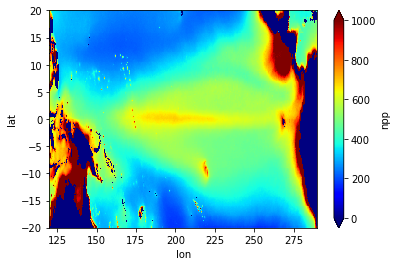

Starting on: mod / vgpm
Creating directory:  datasets/npp_satellite/vgpm_mod
Creating directory:  datasets/npp_satellite/vgpm_mod_extracted
Creating directory:  datasets/npp_satellite/vgpm_mod_opened
Creating directory:  datasets/npp_satellite/vgpm_mod_converted
Creating directory:  datasets/npp_satellite/vgpm_mod_nc
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2002.tar
Downloaded:  datasets/npp_satellite/vgpm_mod/vgpm.m.2002.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2003.tar
Downloaded:  datasets/npp_satellite/vgpm_mod/vgpm.m.2003.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2004.tar
Downloaded:  datasets/npp_satellite/vgpm_mod/vgpm.m.2004.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.chl.m.sst/hdf/vgpm.m.2005.tar
Downloaded:  datasets/npp_satellite/vgpm_mod/vgpm.m.2005.tar
http://orca.science.oregonstate.edu/data/1x2/8day/vgpm.r2018.m.ch

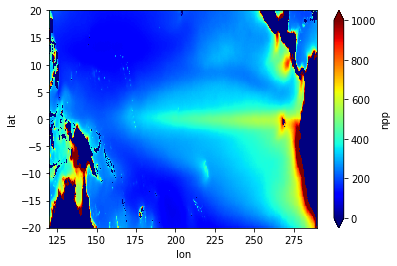

Starting on: mod / eppley
Creating directory:  datasets/npp_satellite/eppley_mod
Creating directory:  datasets/npp_satellite/eppley_mod_extracted
Creating directory:  datasets/npp_satellite/eppley_mod_opened
Creating directory:  datasets/npp_satellite/eppley_mod_converted
Creating directory:  datasets/npp_satellite/eppley_mod_nc
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2002.tar
Downloaded:  datasets/npp_satellite/eppley_mod/eppley.m.2002.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2003.tar
Downloaded:  datasets/npp_satellite/eppley_mod/eppley.m.2003.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2004.tar
Downloaded:  datasets/npp_satellite/eppley_mod/eppley.m.2004.tar
http://orca.science.oregonstate.edu/data/1x2/8day/eppley.r2018.m.chl.m.sst/hdf/eppley.m.2005.tar
Downloaded:  datasets/npp_satellite/eppley_mod/eppley.m.2005.tar
http://orca.science.o

In [ ]:
#'mod_cafe','viirs_vgpm','viirs_eppley','viirs_cbpm','sw_cbpm','sw_cafe','sw_vgbm','
datasets=['sw_eppley','mod_vgpm','mod_eppley','mod_cbpm']
for s in datasets:
    sensor,ppname=s.split('_')
    print('Starting on: '+sensor+' / ' +ppname)
    dat=downloader(eval(s),sensor=sensor,ppname=ppname)
    unzip_extract_convert(sensor=sensor,ppname=ppname)
    
    #PROVE IT OPENS!   
    print('Plotting mean map....')
    data=xr.open_mfdataset('datasets/npp_satellite/'+ppname+'_'+sensor+'_nc/*nc',concat_dim='time',combine='nested')
    data.mean(dim='time').npp.plot(cmap='jet',vmin=0,vmax=1000)
    plt.show()

OTHER PRODUCTS COULD INCLUDE

https://e4ftl01.cr.usgs.gov/MOLA/MYD17A2H.006/
https://lpdaac.usgs.gov/products/myd17a2hv006/    